## **Finding a maximum independant set using a quantum computer with neutral atoms**

The first step is to create a register with a given geometrical graph.

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

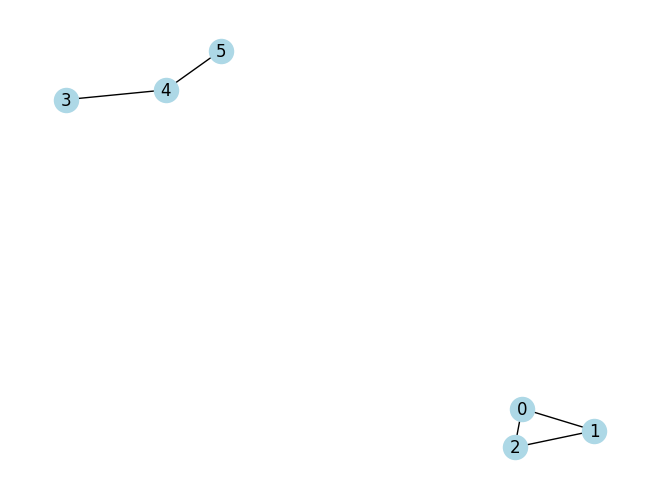

In [14]:
#creating a graph with determinated edges

G = nx.Graph()
edges = np.array([(0, 1), (0, 2), (1,2), (3, 4), (4, 5)]) #be careful, the nodes must be noted from 0 to n where n is the number of total nodes
G.add_edges_from(edges)

#setting the position of the nodes using spring_layout
pos = nx.spring_layout(G, seed = 42)#the seed can be changed, but the seed 42 is used by the Quantum_MIS class

#plot the graph
nx.draw(G, pos = pos, with_labels = True, node_color="lightblue")
plt.show()

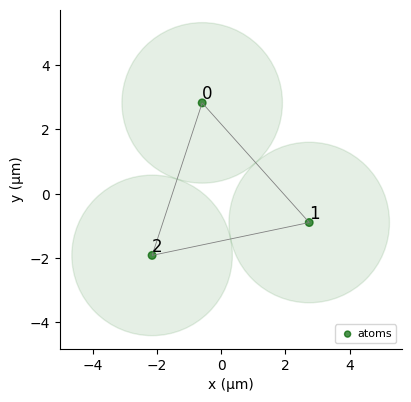

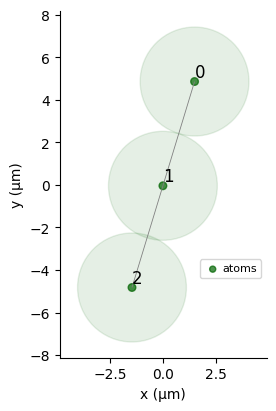

In [15]:
#creating the quantum solver object
from QMIS_code.Quantum_MIS import Quantum_MIS
from pulser.devices import AnalogDevice

#We first want to specify the device used to run the quantum_MIS algorithm 
device = AnalogDevice

#we only need to pass the graph object in the Quantum_MIS class
mis_solution = Quantum_MIS(G, device)

#the Quantum_MIS class creates a register for each connected components
# we can now print the registers created
mis_solution.print_regs() 


Now that we have created the register, we need to create a Pulse. In this project, 5 types of pulse have been implemented. 
- "Rise_sweep_fall" -> A pulse that starts to 0, rises during a quarter of the total time to the omega specified, stays constant during half of the total time, and falls to 0 during a quarter of the total time.

- "Pyramid" -> A pulse that starts at a certain value that is Omega - delta. The pulse stays at this value for a quarter of the total time, does a Rise_Fall pulse for half of the total time, and finally stays constant at Omega-delta for the last quarter of the total time.

- "Blackman" -> This pulse is a normal form with a total area of Omega with a lenght given by the time.

- "Rise_fall" -> This pulse is only the rise and fall part of the Rise_Sweep_Fall pulse. It rises during half of the time from 0 to Omega and falls back to 0 for the last half of the total time.

- "Waveform" -> This pulse starts at 0, is at Omega at half of the total time, and falls back to 0 at the end, but follows a waveform pattern instead of a linear pattern like the Rise_Fall. 

In [16]:
from QMIS_code.pulse_utils import Pulse_constructor

T = 4000 #time of the pulse in ns, the time limit is 4000.

pulse_type = "Rise_sweep_fall" #the pulse type used.

#constructing the pulse using the time and the pulse_type
pulse = Pulse_constructor(T, pulse_type)




It's now time to run the quantum_MIS algorithm. This algorithm takes a graph with all its connected components and resolves it with a quantum adiabatic algorithm and combines them to return a count dictionnary.

In [17]:
shots = 100 #the number of shots doesn't have to be this big for the results to be good

counts_results = mis_solution.run(pulse, progress_bar=False, shots = shots)
print(counts_results)

{'000001': 17, '000100': 16, '000101': 85, '001001': 44, '001100': 43, '001101': 112, '010001': 46, '010100': 45, '010101': 114, '100001': 37, '100100': 36, '100101': 105}


There's an argument in the run meethod named `generate_histogram`. Here's an exemple of the histogram it would produces:

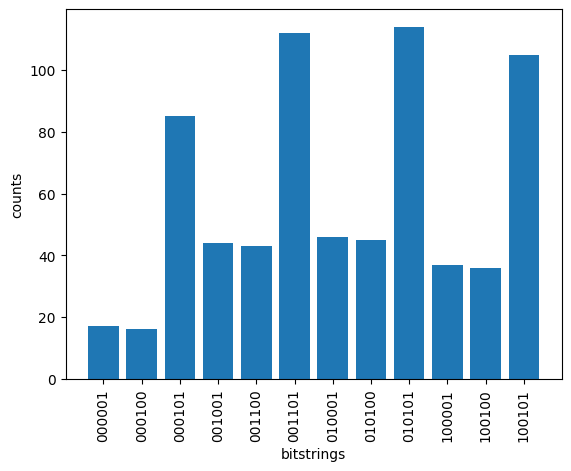

In [18]:
from QMIS_code.QMIS_utils import plot_histogram

plot_histogram(counts_results, shots) #you can also give a file_name in argument in this function to save the histogram in your repository

We can now obtain the maximum independant set of the graph by extracting the maximal bitstring and find the related nodes: 

In [19]:

best_bitstring = max(zip(counts_results.values(),counts_results.keys()))[1]
print("best bitstring in the histogram: ", best_bitstring)

independant_nodes = []
for j in range(len(best_bitstring)):
    if best_bitstring[j] == "1":
        independant_nodes.append(j)

print("nodes contained in the maximal independant set: ", independant_nodes)

best bitstring in the histogram:  010101
nodes contained in the maximal independant set:  [1, 3, 5]


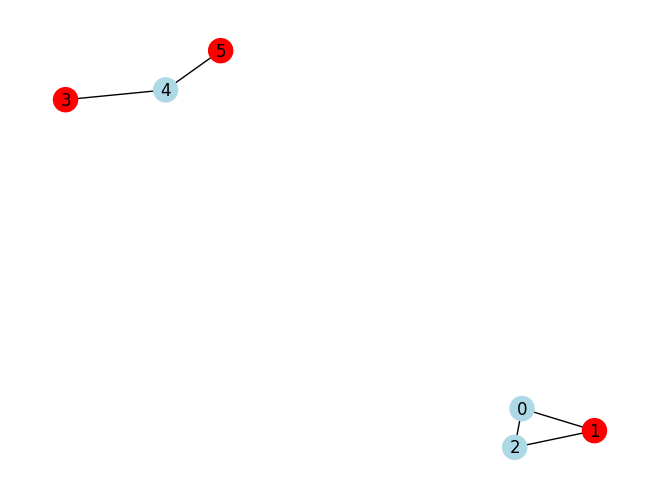

In [20]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
node_colors = ["red" if node in independant_nodes else "lightblue" for node in G.nodes]

nx.draw(G, pos = pos, with_labels = True, node_color = node_colors)
plt.show()

## **Big graph maximal independant set**
We have learned to find the maximal independant set of a graph using a neural atom quantum computer, but this method uses an emulator that doesn't work with a lot of nodes (10 nodes is a lot for this method). We then need to use a function for bigger graph using the quantum_MIS for sub graphes. We will then recombinate them to find the MIS of the total graph.  

First, let's construct a bigger graph that isn't too much confusing.

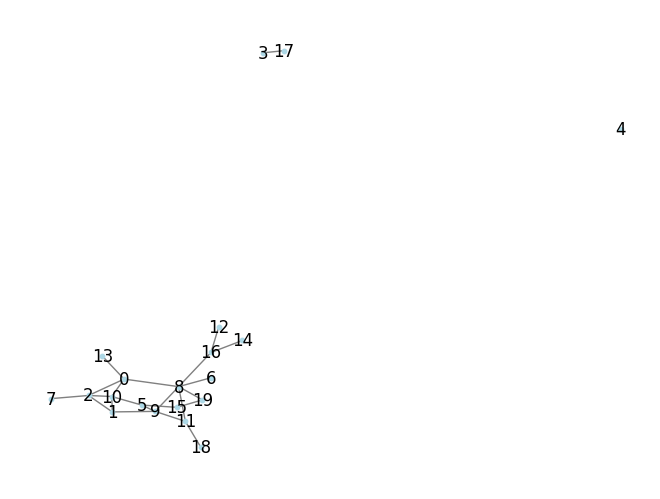

In [ ]:
n_nodes = 20
p_edge = 0.1  # small probability for the graph to not be too dense
big_graph = nx.erdos_renyi_graph(n=n_nodes, p=p_edge, seed=42)

#we need to rename the nodes with a string instead of an int value
mapping = {node: str(node) for node in big_graph.nodes()}
big_graph = nx.relabel_nodes(big_graph, mapping)

pos_2 = nx.spring_layout(big_graph, k=0.1, seed=42)

nx.draw(
    big_graph,
    with_labels=True,
    node_color="lightblue",
    node_size=10, #small nodes to see the edges
    edge_color="gray",
    pos=pos_2,
)
plt.show()

We now want to use our `BIG_QMIS` class that takes a big graph and separates it in smaller graphes.

In [22]:
from Big_QMIS import BIG_QMIS

solver = BIG_QMIS(big_graph, 10)#the number 10 stands for the number of nodes in the small graphes that will be solved by the regular Quantum_MIS


Let's create a new pulse to test the BIG_QMIS. The bIG_QMIS returns the maximal indenpendant set in the format of a list of nodes. 

In [23]:
Pulse = Pulse_constructor(4000, "Waveform")

MIS = solver.run(Pulse, shots = 1000, print_progression= True)

print(MIS)

Partionned the graph
Sub_graphes created
MIS' done. Now combining
['5', '6', '8', '9', '11', '12', '14', '15', '16', '18', '19', '0', '1', '2', '3', '4', '7', '10', '13', '17']


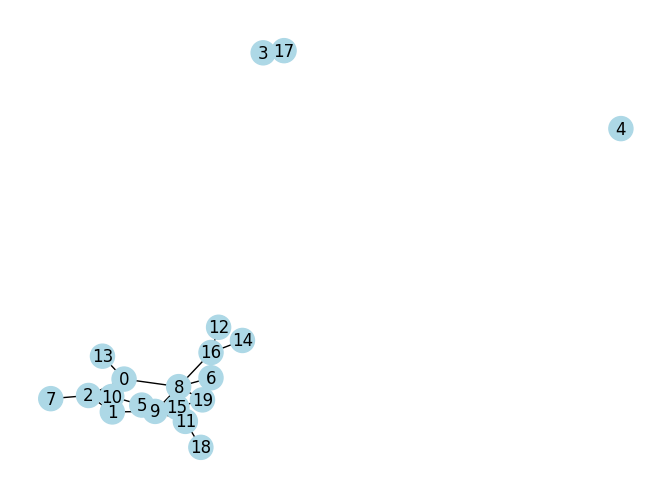

In [24]:
#the red nodes are part of the maximal independant set and the blue nodes are not part of the maximal independant set
nodes_color = ["red" if node in MIS else "lightblue" for node in big_graph.nodes]

nx.draw(big_graph, pos = pos_2, with_labels = True, node_color = nodes_color)
plt.show()